### Import the model and load with pretrained weights

In [1]:
import torch
from model import AutoRegressiveFlow
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

flow = AutoRegressiveFlow(1, num_layers=5, n_components=10)
flow.load_state_dict(torch.load('trained_weights.pt', map_location='cpu'))

<All keys matched successfully>

### Code to sample 

In [2]:
from torch.distributions.normal import Normal

def sample(flow, num_samples):
    n_channels, height, width = 1, 20, 20
    result = torch.zeros(num_samples, n_channels, height, width)
    with torch.no_grad():
        for row in range(height):
            for col in range(width):
                for channel in range(n_channels):
                    model_output = flow.model(result)
                    mus, log_sigmas, weight_logits = torch.chunk(model_output, 3, dim=1)
                    
                    mus = mus.view(num_samples, flow.n_components, n_channels, height, width)
                    log_sigmas = log_sigmas.view(num_samples, flow.n_components, n_channels, height, width)
                    weight_logits = weight_logits.view(num_samples, flow.n_components, n_channels, height, width)
                    
                    # get the mus, sigmas and weights for pixel at (channel, row, col)
                    mus = mus[:,:,channel, row, col]
                    log_sigmas = log_sigmas[:,:,channel, row, col]
                    weight_logits = weight_logits[:,:,channel, row, col]
                    weights = weight_logits.softmax(dim=1)
                    
                    # a sample at (channel, row, col) comes from a mixture of Gaussians
                    # where the probability of the Gaussian `i` is given by `weights[i]`
                    indices_of_gaussians_to_sample_from = torch.multinomial(weights, 1).squeeze(-1)
                    zero_to_num_samples = torch.arange(num_samples)
                    mus_per_batch = mus[zero_to_num_samples, indices_of_gaussians_to_sample_from]
                    sigmas_per_batch = log_sigmas[zero_to_num_samples, indices_of_gaussians_to_sample_from].exp()
                    result[:, channel, row, col] = torch.normal(mus_per_batch, sigmas_per_batch)
    return result

### Some generated samples

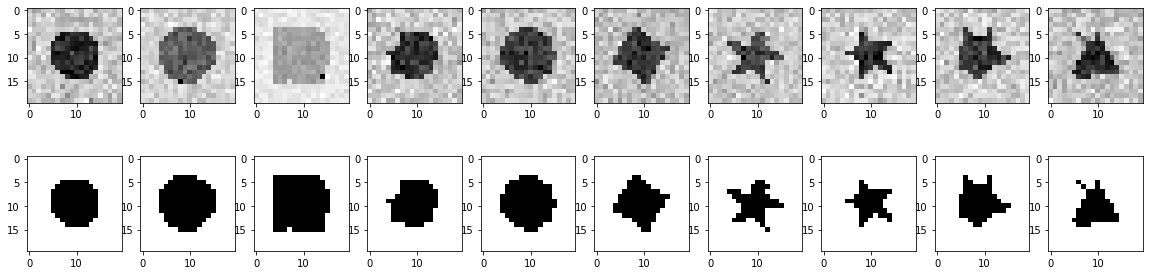

In [6]:
out = sample(flow, 10)
_, axes = plt.subplots(2,10,figsize=(20,5))

for i in range(10):
    _ = axes[0][i].imshow((out[i].squeeze().numpy()).astype(np.float32) , 'gray')
    _ = axes[1][i].imshow((out[i].squeeze().numpy()).astype(np.float32) > 0.375 , 'gray')